# NLP and Scoring

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import 	WordNetLemmatizer
from sklearn.model_selection import StratifiedKFold
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### Load data

In [28]:
df = pd.read_csv("anime_with_synopsis.csv")
print(len(df))
df.head(10)

16214


,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college..."
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent..."


In [29]:
print(df.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')


### Preprocess data/ Clean null entires

In [30]:
#Data Cleaning
# Drop all the rows with Unknown in the 'Score' column
print(df[df['Score'] == 'Unknown'].head(5))
df = df[df['Score'] != 'Unknown']
# Drop all the rows with no synopsis information
print(df[df['sypnopsis'] == 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'].head(5))
df = df[df['sypnopsis'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .']
print(f"Length after Removing Unknow entries: {len(df)}" )

      MAL_ID                                               Name    Score  \
1347    1547                                   Obake no Q-tarou  Unknown   
1439    1656                                    PostPet Momobin  Unknown   
1512    1739                         Shibawanko no Wa no Kokoro  Unknown   
1619    1863                            Silk Road Shounen Yuuto  Unknown   
1808    2073  Hengen Taima Yakou Karura Mau! Sendai Kokeshi ...  Unknown   

                                           Genres  \
1347  Comedy, School, Slice of Life, Supernatural   
1439                                 Comedy, Kids   
1512                                         Kids   
1619               Adventure, Fantasy, Historical   
1808                               Horror, Shoujo   

                                              sypnopsis  
1347  Q-taro, a monster, is living with the Ohara fa...  
1439  omo and Komomo can deliver mail from anyone, t...  
1512  Based on a japanese children`s book by Yoshi

In [31]:
#Turing data into desired format
df['Score'] = df['Score'].astype(float)
df['sypnopsis'] = df['sypnopsis'].astype(str)
df.reset_index(drop=True, inplace=True)
df.head(10)
df['Score_class'] = df['Score'].apply(lambda x: 1 if x >= 7.25 else 0)

### Tokenize data, remove stop words and lemmitize

In [32]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

df["tokenized"] = ""
for i in range(len(df)):
    df.loc[i,'sypnopsis'] = df.loc[i,'sypnopsis'].lower()
    df.loc[i,'sypnopsis'] = decontracted(df.loc[i,'sypnopsis'])
    word_tokens = tokenizer.tokenize(df.loc[i,'sypnopsis'])
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(w) for w in word_tokens]
    filtered_sentence = [w for w in lemmatized_tokens if not w in stop_words and not w.isdigit()]
    df.loc[i,'tokenized'] = " ".join(filtered_sentence)
df.head(10)

,MAL_ID,Name,Score,Genres,sypnopsis,Score_class,tokenized
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","in the year 2071, humanity has colonized sever...",1,year humanity ha colonized several planet moon...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1,day another bounty life often unlucky crew beb...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","vash the stampede is the man with a $$60,000,0...",1,vash stampede man bounty head reason merciless...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,1,ches individual special power like esp telekin...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",it is the dark century and the people are suff...,0,dark century people suffering rule devil vande...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",sena is like any other shy kid starting high s...,1,sena like shy kid starting high school trying ...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","yuuta takemoto, a sophomore at an arts college...",1,yuuta takemoto sophomore art college share che...
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",kyosuke kano has lived under the shadow of his...,1,kyosuke kano ha lived shadow successful brothe...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",takumi fujiwara finally joins ryousuke and kei...,1,takumi fujiwara finally join ryousuke keisuke ...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","dr. kenzou tenma, an elite neurosurgeon recent...",1,dr kenzou tenma elite neurosurgeon recently en...


### Apply TF-IDF on the tokenized data

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['tokenized'], df['Score'], test_size=0.25, random_state=42)
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(df['tokenized'], df['Score_class'], test_size=0.3, random_state=42)
bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)

# Preprocess the synopsis text data
vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Preprocess the synopsis text data for binary classification
bin_vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
bin_vectorizer.fit(bin_X_train)
bin_X_train = bin_vectorizer.transform(bin_X_train)
bin_X_test = bin_vectorizer.transform(bin_X_test)
bin_X_val = bin_vectorizer.transform(bin_X_val)



In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")


R2 Score: 0.25801794078917384
Mean Squared Error: 0.6360313933399894
Mean Absolute Error: 0.6174331131684736


In [35]:
bin_X_train = bin_X_train.toarray()
bin_X_test = bin_X_test.toarray()
bin_X_val = bin_X_val.toarray()

### Train a Sequential model on the TF-IDF data

In [36]:
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    # tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Train the model
history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)

c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7603 - loss: 3.5152 - val_accuracy: 0.7587 - val_loss: 3.3937
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7666 - loss: 3.3524 - val_accuracy: 0.7587 - val_loss: 3.2396
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7753 - loss: 3.1983 - val_accuracy: 0.7587 - val_loss: 3.0934
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7679 - loss: 3.0558 - val_accuracy: 0.7587 - val_loss: 2.9538
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7723 - loss: 2.9167 - val_accuracy: 0.7587 - val_loss: 2.8208
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7713 - loss: 2.7857 - val_accuracy: 0.7587 - val_loss: 2.6942
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7694 - loss: 2.6611 - val_accuracy: 0.7587 - val_loss: 2.5737
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7719 - loss: 2.5418 - val_accuracy: 0.7587 - val

In [37]:
# Evaluate the model
loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
print(f'Test accuracy: {accuracy}')

y_pred_prob = model.predict(bin_X_test)

y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(bin_y_test, y_pred))

23/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7616 - loss: 0.4406 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7593 - loss: 0.4445
Test accuracy: 0.7643467783927917
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1216
           1       0.60      0.25      0.35       422

    accuracy                           0.76      1638
   macro avg       0.69      0.60      0.60      1638
weighted avg       0.74      0.76      0.73      1638



### Plot the model los and validation loss vs the number of epochs

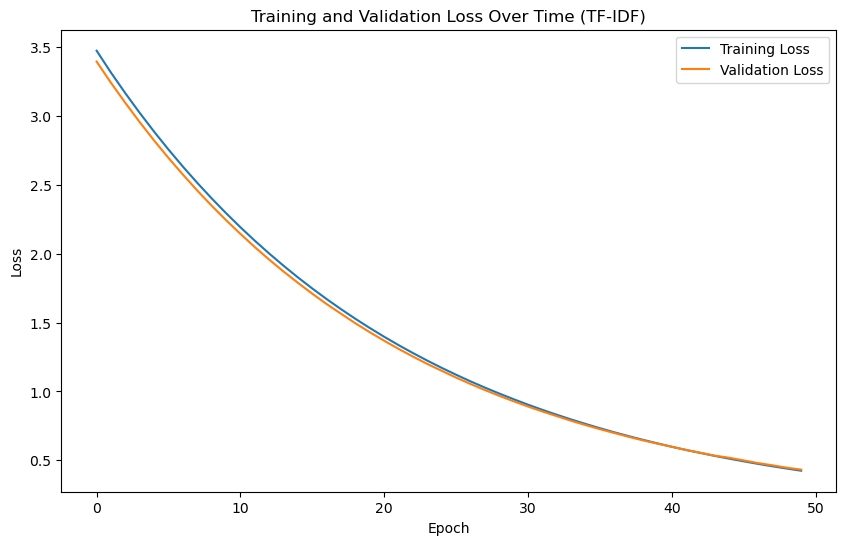

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time (TF-IDF)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7430 - loss: 3.5113 - val_accuracy: 0.7489 - val_loss: 3.3722
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7625 - loss: 3.3246 - val_accuracy: 0.7498 - val_loss: 3.1976
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7665 - loss: 3.1514 - val_accuracy: 0.7498 - val_loss: 3.0327
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7689 - loss: 2.9886 - val_accuracy: 0.7498 - val_loss: 2.8773
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7688 - loss: 2.8346 - val_accuracy: 0.7534 - val_loss: 2.7292
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7690 - loss: 2.6894 - val_accuracy: 0.7516 - val_loss: 2.5898
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7643 - loss: 2.5531 - val_accuracy: 0.7599 - val_loss: 2.4578
Epoch 

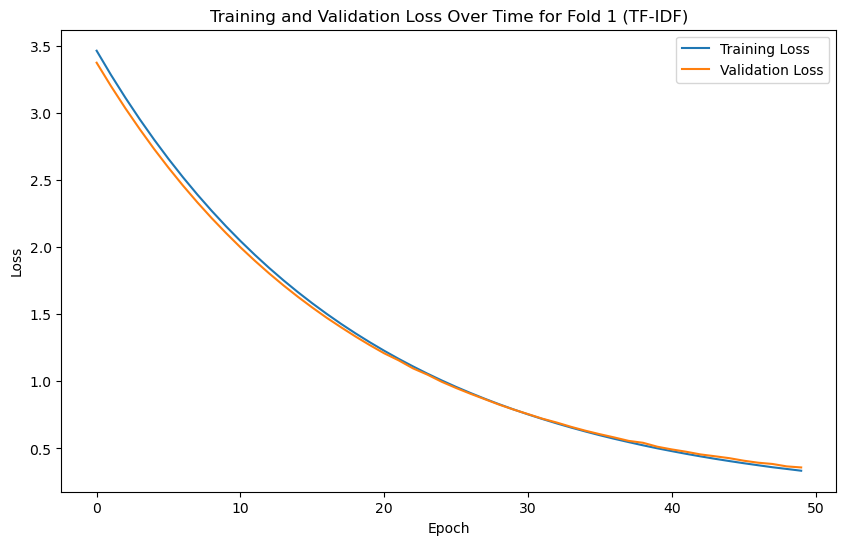

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7492 - loss: 3.5107 - val_accuracy: 0.7461 - val_loss: 3.3739
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7582 - loss: 3.3253 - val_accuracy: 0.7461 - val_loss: 3.1991
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7640 - loss: 3.1517 - val_accuracy: 0.7461 - val_loss: 3.0347
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7618 - loss: 2.9891 - val_accuracy: 0.7461 - val_loss: 2.8786
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7648 - loss: 2.8346 - val_accuracy: 0.7470 - val_loss: 2.7311
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7514 - loss: 2.6923 - val_accuracy: 0.7479 - val_loss: 2.5917
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7704 - loss: 2.5516 - val_accuracy: 0.7516 - val_loss: 2.4595
Epoch 8

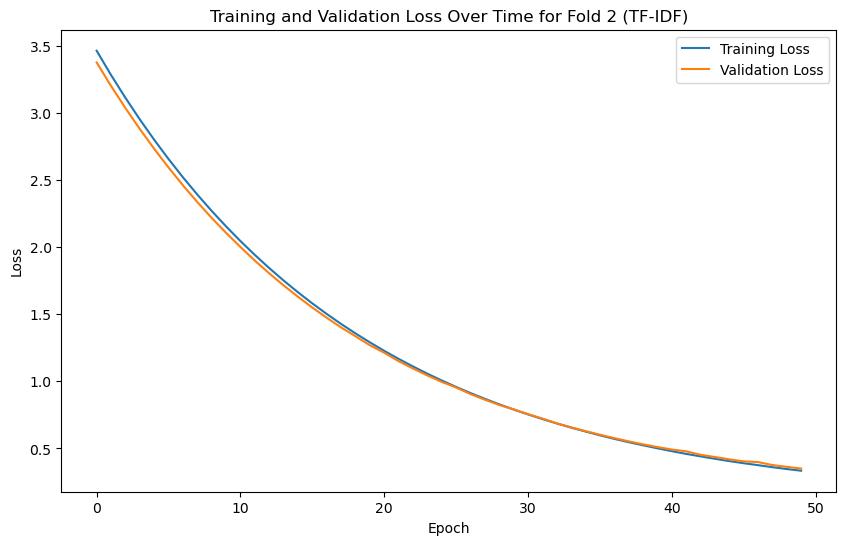

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7361 - loss: 3.5100 - val_accuracy: 0.7589 - val_loss: 3.3677
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7560 - loss: 3.3250 - val_accuracy: 0.7589 - val_loss: 3.1945
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7652 - loss: 3.1510 - val_accuracy: 0.7589 - val_loss: 3.0295
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7655 - loss: 2.9887 - val_accuracy: 0.7589 - val_loss: 2.8741
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7665 - loss: 2.8353 - val_accuracy: 0.7589 - val_loss: 2.7269
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7645 - loss: 2.6915 - val_accuracy: 0.7589 - val_loss: 2.5875
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7633 - loss: 2.5529 - val_accuracy: 0.7589 - val_loss: 2.4556
Epoch 8

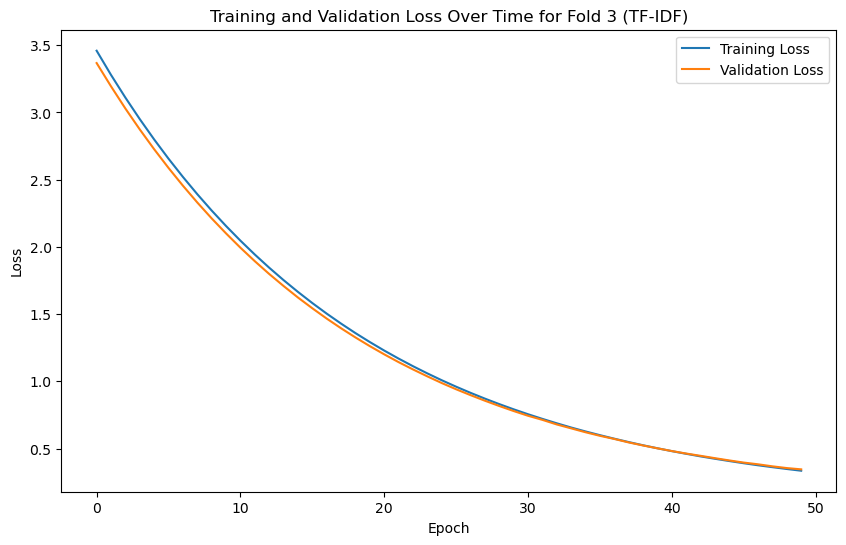

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7559 - loss: 3.5088 - val_accuracy: 0.7608 - val_loss: 3.3684
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7578 - loss: 3.3242 - val_accuracy: 0.7608 - val_loss: 3.1942
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7582 - loss: 3.1524 - val_accuracy: 0.7608 - val_loss: 3.0295
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7624 - loss: 2.9886 - val_accuracy: 0.7608 - val_loss: 2.8742
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7598 - loss: 2.8358 - val_accuracy: 0.7608 - val_loss: 2.7265
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7542 - loss: 2.6923 - val_accuracy: 0.7617 - val_loss: 2.5872
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7629 - loss: 2.5531 - val_accuracy: 0.7690 - val_loss: 2.4553
Epoch 8

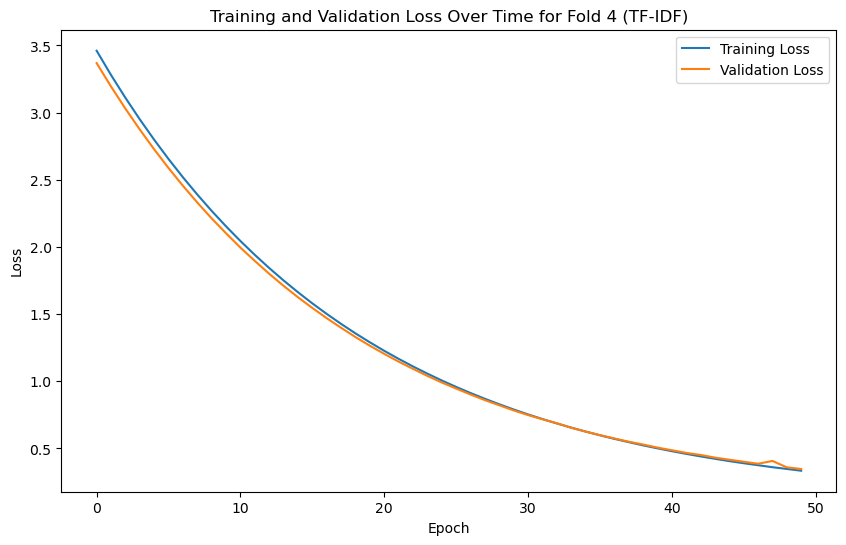

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7572 - loss: 3.5108 - val_accuracy: 0.7644 - val_loss: 3.3696
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7612 - loss: 3.3267 - val_accuracy: 0.7644 - val_loss: 3.1949
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7639 - loss: 3.1535 - val_accuracy: 0.7644 - val_loss: 3.0301
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7616 - loss: 2.9917 - val_accuracy: 0.7644 - val_loss: 2.8744
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7645 - loss: 2.8373 - val_accuracy: 0.7654 - val_loss: 2.7268
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7654 - loss: 2.6915 - val_accuracy: 0.7654 - val_loss: 2.5872
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7615 - loss: 2.5547 - val_accuracy: 0.7654 - val_loss: 2.4553
Epoch 8

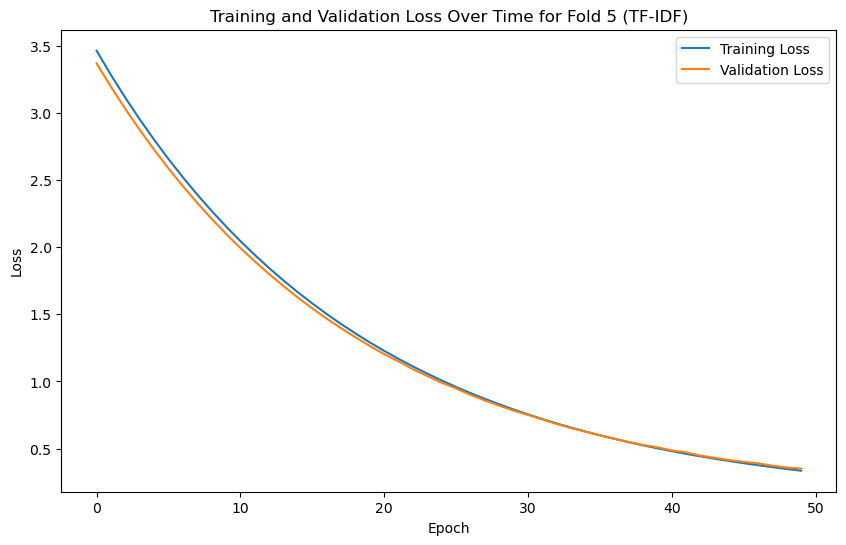

In [39]:
X = df['tokenized']
y = df['Score_class']

kFold = StratifiedKFold(n_splits=5, shuffle=True)

i = 1

accuracies = []

for train_index, test_index in kFold.split(X, y):
    bin_X_train, bin_X_test = X.iloc[train_index], X.iloc[test_index]
    bin_y_train, bin_y_test = y.iloc[train_index], y.iloc[test_index]
    bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)
    bin_vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
    bin_vectorizer.fit(bin_X_train)
    bin_X_train = bin_vectorizer.transform(bin_X_train)
    bin_X_test = bin_vectorizer.transform(bin_X_test)
    bin_X_val = bin_vectorizer.transform(bin_X_val)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)
    loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
    accuracies.append(accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Time for Fold ' + str(i) + ' (TF-IDF)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    i+=1
    

In [40]:
mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy: {mean_accuracy}')
print(accuracies)

Mean accuracy: 0.7798534750938415
[0.7756410241127014, 0.7902930378913879, 0.7930402755737305, 0.7902930378913879, 0.75]


<ErrorbarContainer object of 3 artists>

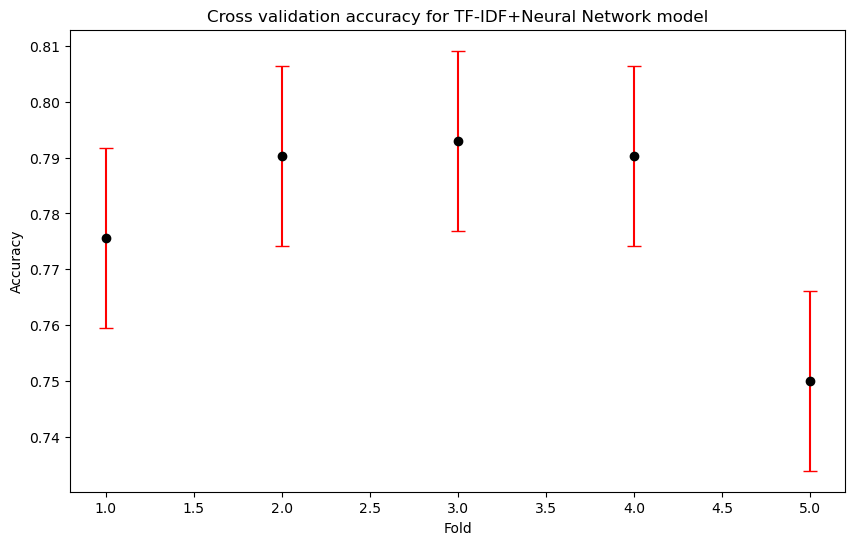

In [41]:
plt.figure(figsize=(10, 6))
plt.title('Cross validation accuracy for TF-IDF+Neural Network model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.errorbar(range(1, 6), accuracies, yerr=np.std(accuracies), fmt='o', color='black', ecolor='red', capsize=5)

### Using CountVectorizer to vecotrize the data

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['sypnopsis'], df['Score'], test_size=0.25, random_state=42)
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(df['sypnopsis'], df['Score_class'], test_size=0.3, random_state=42)
bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)


# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


# Initialize the CountVectorizer for binary classification
bin_vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
bin_vectorizer.fit(bin_X_train)
bin_X_train = bin_vectorizer.transform(bin_X_train)
bin_X_test = bin_vectorizer.transform(bin_X_test)
bin_X_val = bin_vectorizer.transform(bin_X_val)




### Train a linear regression model

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Fit the LinearRegression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

R^2 score: 0.18753950818940113
Mean squared error: 0.6964459210639206
Mean absolute error: 0.6472748584149342


In [44]:
bin_X_train = bin_X_train.toarray()
bin_X_test = bin_X_test.toarray()
bin_X_val = bin_X_val.toarray()

### Create a sequentail neural network model and train it on the data

In [45]:
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Train the model
history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)

Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7241 - loss: 3.5236 - val_accuracy: 0.7801 - val_loss: 3.3780
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7877 - loss: 3.3392 - val_accuracy: 0.7868 - val_loss: 3.2230
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7963 - loss: 3.1847 - val_accuracy: 0.7825 - val_loss: 3.0789
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7903 - loss: 3.0426 - val_accuracy: 0.7917 - val_loss: 2.9373
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8023 - loss: 2.9001 - val_accuracy: 0.7966 - val_loss: 2.8047
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8129 - loss: 2.7668 - val_accuracy: 0.7905 - val_loss: 2.6803
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8044 - loss: 2.6445 - val_accuracy: 0.7947 - val_loss: 2.5594
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8180 - loss: 2.5224 - val_accuracy: 0.7966 - val_

### Plot the model loss and validation loss vs the number of epochs

In [46]:
# Evaluate the model
loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
print(f'Test accuracy: {accuracy}')

y_pred_prob = model.predict(bin_X_test)

y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(bin_y_test, y_pred))

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8125 - loss: 0.4414

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7337 - loss: 0.4716
Test accuracy: 0.7222222089767456
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1216
           1       0.47      0.55      0.50       422

    accuracy                           0.72      1638
   macro avg       0.65      0.67      0.66      1638
weighted avg       0.74      0.72      0.73      1638



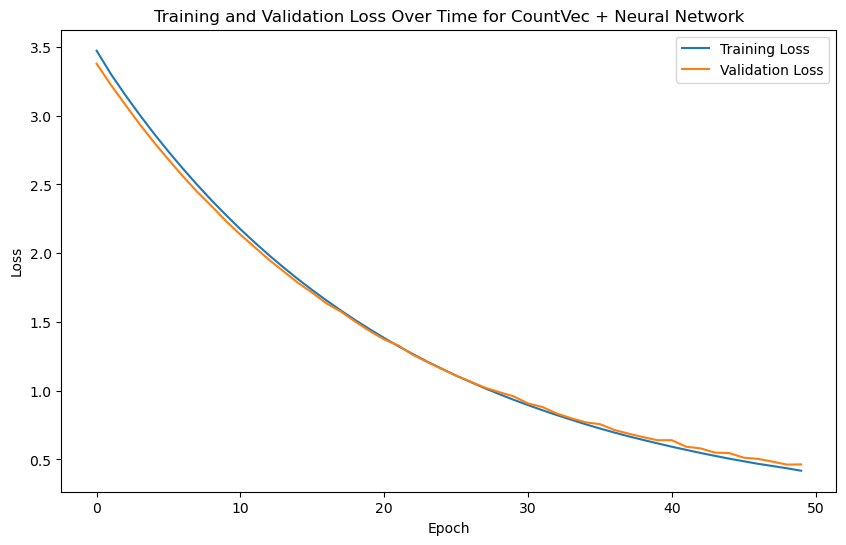

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time for CountVec + Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7356 - loss: 3.5123 - val_accuracy: 0.7507 - val_loss: 3.3631
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7715 - loss: 3.3135 - val_accuracy: 0.7599 - val_loss: 3.1871
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7909 - loss: 3.1380 - val_accuracy: 0.7699 - val_loss: 3.0230
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7890 - loss: 2.9766 - val_accuracy: 0.7736 - val_loss: 2.8677
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7943 - loss: 2.8222 - val_accuracy: 0.7709 - val_loss: 2.7228
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8044 - loss: 2.6770 - val_accuracy: 0.7809 - val_loss: 2.5811
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8082 - loss: 2.5385 - val_accuracy: 0.7764 - val_loss: 2.4504
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8040 - loss: 2.4126 - val_accuracy: 0.7800 - val

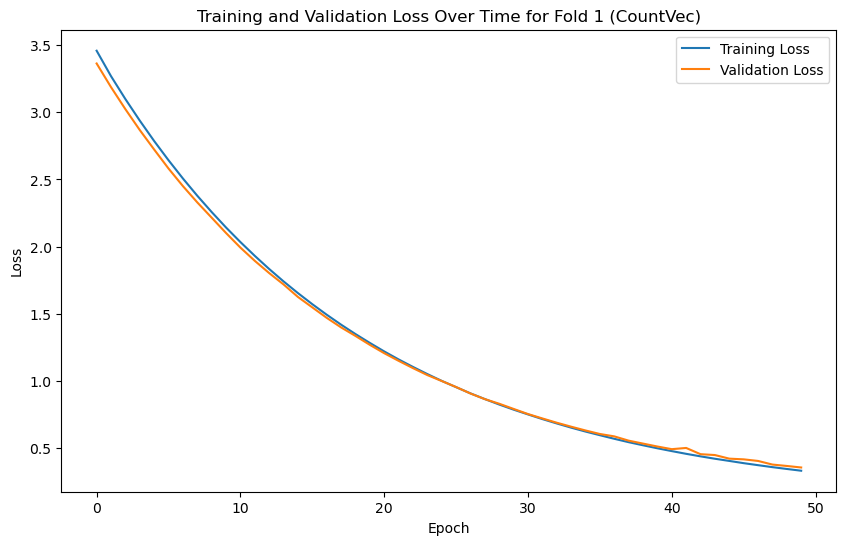

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7061 - loss: 3.5203 - val_accuracy: 0.7626 - val_loss: 3.3632
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7758 - loss: 3.3132 - val_accuracy: 0.7764 - val_loss: 3.1881
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7915 - loss: 3.1388 - val_accuracy: 0.7754 - val_loss: 3.0243
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7854 - loss: 2.9791 - val_accuracy: 0.7791 - val_loss: 2.8697
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7972 - loss: 2.8235 - val_accuracy: 0.7690 - val_loss: 2.7248
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8094 - loss: 2.6767 - val_accuracy: 0.7690 - val_loss: 2.5873
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8003 - loss: 2.5432 - val_accuracy: 0.7828 - val_loss: 2.4556
Epoch 8

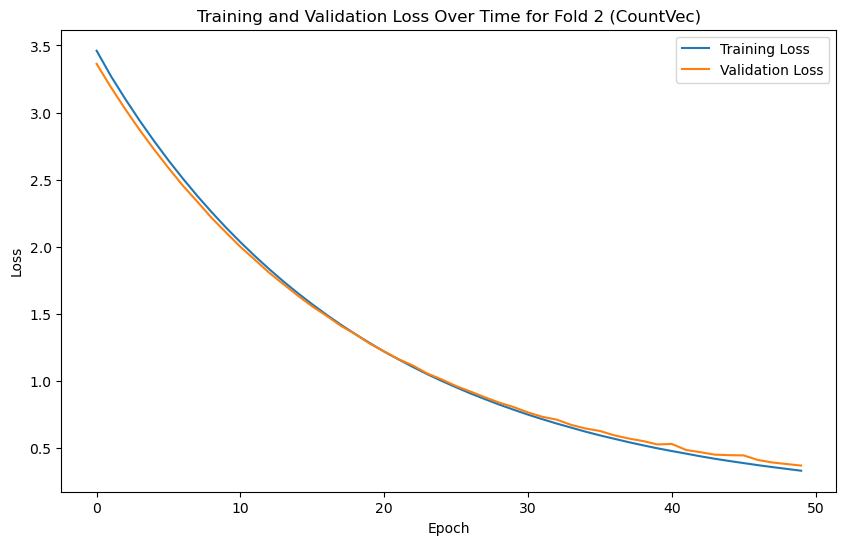

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7155 - loss: 3.5163 - val_accuracy: 0.7507 - val_loss: 3.3664
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7829 - loss: 3.3131 - val_accuracy: 0.7608 - val_loss: 3.1912
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7921 - loss: 3.1385 - val_accuracy: 0.7635 - val_loss: 3.0281
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7843 - loss: 2.9788 - val_accuracy: 0.7553 - val_loss: 2.8762
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7922 - loss: 2.8237 - val_accuracy: 0.7690 - val_loss: 2.7276
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7982 - loss: 2.6800 - val_accuracy: 0.7654 - val_loss: 2.5899
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8051 - loss: 2.5406 - val_accuracy: 0.7727 - val_loss: 2.4580
Epoch 8

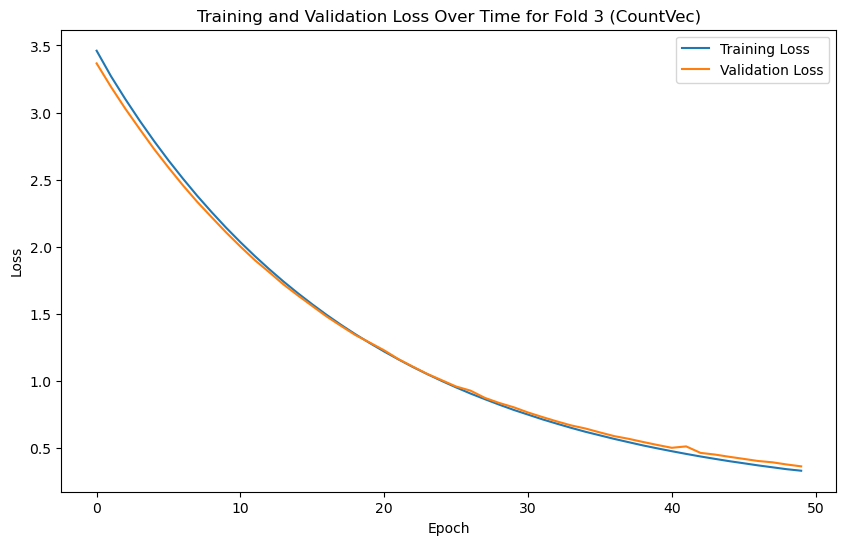

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7155 - loss: 3.5136 - val_accuracy: 0.7791 - val_loss: 3.3578
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7807 - loss: 3.3084 - val_accuracy: 0.7883 - val_loss: 3.1827
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7922 - loss: 3.1357 - val_accuracy: 0.7855 - val_loss: 3.0188
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7853 - loss: 2.9769 - val_accuracy: 0.7901 - val_loss: 2.8643
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8035 - loss: 2.8188 - val_accuracy: 0.7892 - val_loss: 2.7181
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8005 - loss: 2.6763 - val_accuracy: 0.7819 - val_loss: 2.5806
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7973 - loss: 2.5403 - val_accuracy: 0.7892 - val_loss: 2.4491
Epoch 8

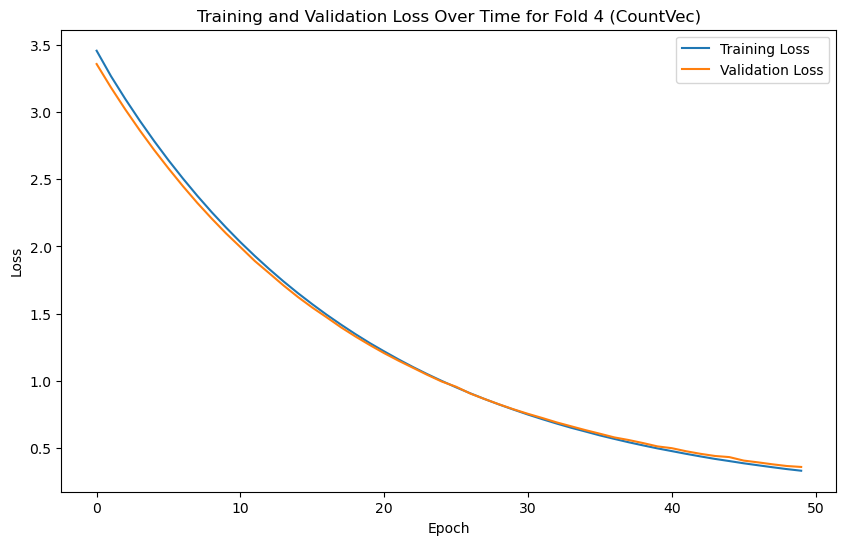

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7182 - loss: 3.5179 - val_accuracy: 0.7773 - val_loss: 3.3618
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7822 - loss: 3.3131 - val_accuracy: 0.7791 - val_loss: 3.1862
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7892 - loss: 3.1396 - val_accuracy: 0.7846 - val_loss: 3.0236
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8004 - loss: 2.9760 - val_accuracy: 0.7965 - val_loss: 2.8664
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8018 - loss: 2.8218 - val_accuracy: 0.7947 - val_loss: 2.7208
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8041 - loss: 2.6774 - val_accuracy: 0.7938 - val_loss: 2.5848
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8025 - loss: 2.5397 - val_accuracy: 0.7901 - val_loss: 2.4545
Epoch 8

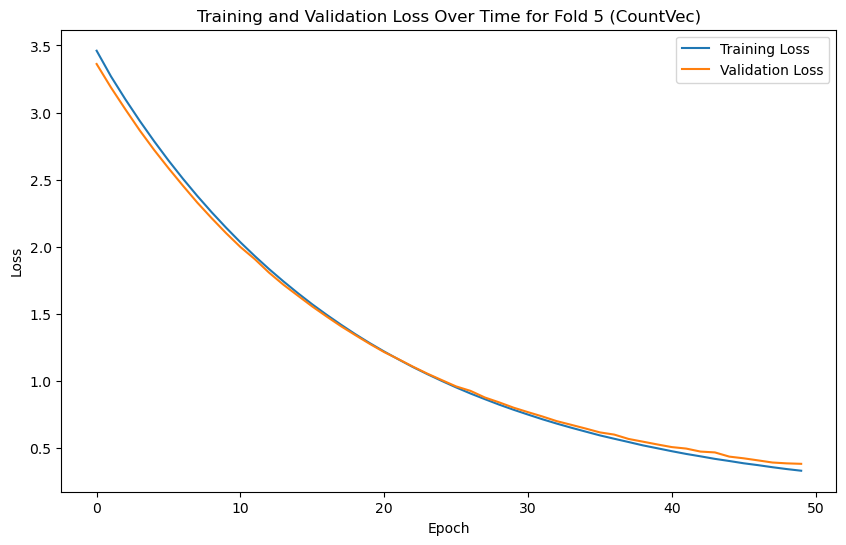

In [48]:
X = df['sypnopsis']
y = df['Score_class']

kFold = StratifiedKFold(n_splits=5, shuffle=True)

i = 1

accuracies = []

for train_index, test_index in kFold.split(X, y):
    bin_X_train, bin_X_test = X.iloc[train_index], X.iloc[test_index]
    bin_y_train, bin_y_test = y.iloc[train_index], y.iloc[test_index]
    bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)
    
    bin_vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
    bin_vectorizer.fit(bin_X_train)
    bin_X_train = bin_vectorizer.transform(bin_X_train)
    bin_X_test = bin_vectorizer.transform(bin_X_test)
    bin_X_val = bin_vectorizer.transform(bin_X_val)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)
    loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
    accuracies.append(accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Time for Fold ' + str(i) + ' (CountVec)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    i+=1
    

In [49]:
mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy: {mean_accuracy}')
print(accuracies)

Mean accuracy: 0.7890109896659852
[0.7838827967643738, 0.7930402755737305, 0.7948718070983887, 0.7719780206680298, 0.8012820482254028]


<ErrorbarContainer object of 3 artists>

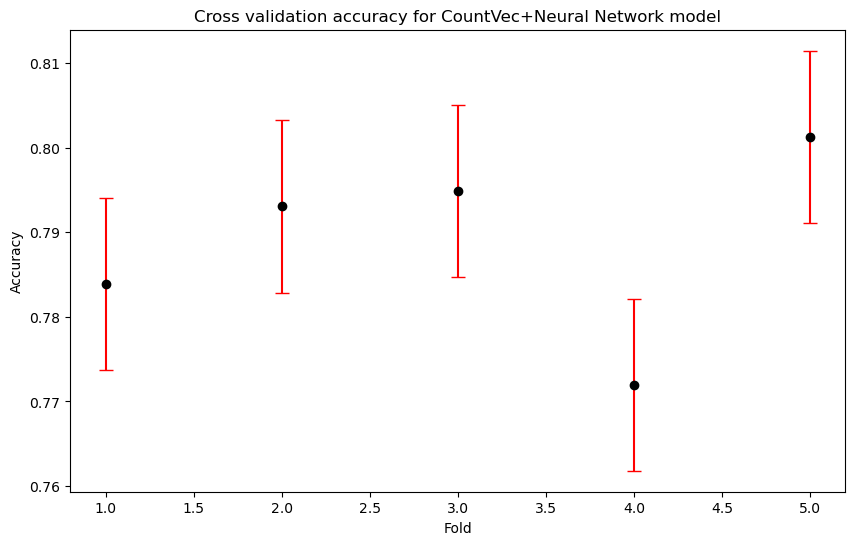

In [50]:
plt.figure(figsize=(10, 6))
plt.title('Cross validation accuracy for CountVec+Neural Network model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.errorbar(range(1, 6), accuracies, yerr=np.std(accuracies), fmt='o', color='black', ecolor='red', capsize=5)